In [1]:
import ee
ee.Initialize()
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def maskS2clouds(image): 
    qa = image.select('QA60');
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10;
    cirrusBitMask = 1 << 11;
    #Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0)
    mask = mask.bitwiseAnd(cirrusBitMask).eq(0)
    return (image.updateMask(mask).divide(10000))

In [15]:
#Map the function over one year of data and take the median.
#Load Sentinel-2 TOA reflectance data.

date1 = ee.Date('2020-01-10')
date2 = ee.Date('2020-04-26')


#Pre-filter to get less cloudy granules.
dataset = ee.ImageCollection('COPERNICUS/S2').filterDate(date1, date2).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)).map(maskS2clouds)

In [37]:
#Function to calculate and add an NDVI band
def addNDVI(image):
    return (image.addBands(image.normalizedDifference(['B8', 'B4'])))


#Add NDVI band to image collection
S2 = dataset.map(addNDVI);    
S2_median=S2.reduce(ee.Reducer.mean())

In [38]:
point = ee.Geometry.Point(-63.3189,-33.4217) #Longitud - Latitud

l = S2.filterBounds(point).getRegion(point, 30).getInfo()

out = [dict(zip(l[0], values)) for values in l[1:]]

Dates=np.zeros(len(out)).tolist()
NDVI=np.zeros(len(out)).tolist()
df=pd.DataFrame()

for i in range(len(out)):
    a=out[i]['id']
    b=a.split(sep='_')
    b1=b[0]
    b2=b1.split(sep='T')
    Dates[i]=datetime.strptime(b2[0], "%Y%m%d")
    NDVI[i]=out[i]['nd']

df['Dates'] = Dates
df['NDVI']=NDVI
df.set_index('Dates', inplace=True)
#return(df)
print(df)

                NDVI
Dates               
2020-01-15  0.832787
2020-01-20  0.678169
2020-01-25  0.850362
2020-01-30  0.855652
2020-02-04  0.784026
2020-02-14  0.843756
2020-02-19  0.804537
2020-02-24  0.845034
2020-02-29  0.822517
2020-03-05  0.774487
2020-03-20  0.465477
2020-03-30  0.262896
2020-04-04  0.252160
2020-04-09  0.190497
2020-04-14  0.198131
2020-04-19  0.189338
2020-04-24  0.190242


In [39]:
df.head(20)

,NDVI
Dates,
2020-01-15,0.832787
2020-01-20,0.678169
2020-01-25,0.850362
2020-01-30,0.855652
2020-02-04,0.784026
2020-02-14,0.843756
2020-02-19,0.804537
2020-02-24,0.845034
2020-02-29,0.822517


In [40]:
df.describe()

,NDVI
count,17.000000
mean,0.578827
std,0.293077
min,0.189338
25%,0.252160
50%,0.774487
75%,0.832787
max,0.855652


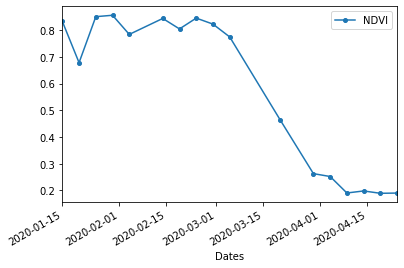

In [46]:
df.plot(label='NDVI',markersize=8,marker='.', linestyle='-')